# Introduction

Implementing kernels designed in Automatic forecasting using Gaussian Process [1] and test results with the M4 dataset. For now, only small sections of the M4 training and testing datasets are being used.



In [1]:
# Get this to work on GPUs.
from pandas.core.groupby.generic import DataFrameGroupBy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
!pip install gpytorch # This is to allow gpytorch to work on any Google Colab Notebook
import gpytorch as gp
import random

  Using cached gpytorch-1.8.1-py2.py3-none-any.whl (361 kB)


Setting up the full m4 dataset and any subsets (ex. monthly, weekly, hourly, etc.) that might be analyzed.

In [2]:
random.seed(0)
df = pd.read_csv('M4-info.csv') # This is for the m4 dataset as a whole
df_test = pd.read_csv("Monthly-test.csv") # Monthly dataset for testing purposes
df_train = pd.read_csv("Monthly-train.csv") # Monthly dataset for training purposes

## Setting a new dataset with one row from the training dataset
We visualize the data of one row in the M4 dataset and put that rows into its own dataset, which will now be used for the training dataset.


In [3]:
df_2 = df_train.loc[2574].to_frame() # This is a dataframe housing the row that I chose, which I believe is the one with the most elements.
df_2 = df_2.dropna()
df_2 = pd.DataFrame(df_2) # Just confirming that we made a new dataframe
df_2["index"] = df_2.index # There are the indexes corresponding to each element
items = df_2.iloc[:, 0]
df_2 = df_2.assign(items=items)
df_2 = df_2.drop("V1")
df_2['index'] = df_2['index'].str.replace('V', '') # Removing V from each index so that indecies are numbers
df_2

,2574,index,items
V2,4200.0,2,4200.0
V3,4218.0,3,4218.0
V4,4200.0,4,4200.0
V5,4200.0,5,4200.0
V6,4221.0,6,4221.0
...,...,...,...
V1850,12655.0,1850,12655.0
V1851,12324.0,1851,12324.0
V1852,12386.0,1852,12386.0
V1853,12260.0,1853,12260.0


Text(0, 0.5, 'Value')

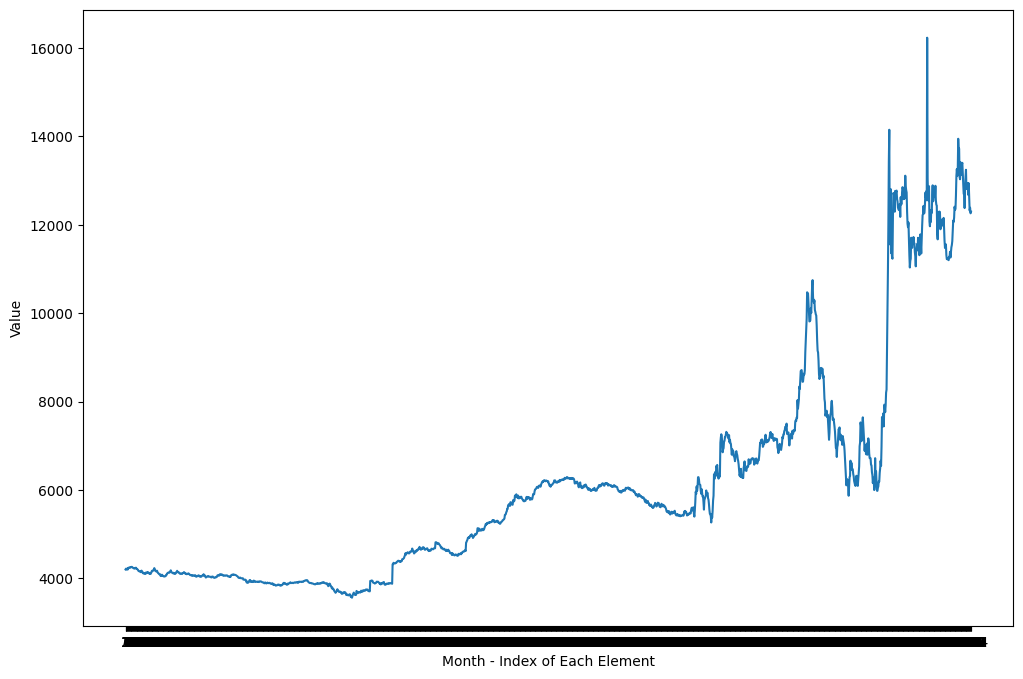

In [4]:
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='index', y='items', data=df_2) # Revised based on how I formatted the dataset.
plt.xlabel('Month - Index of Each Element')
plt.ylabel('Value')

## Plotting the auto-correlation
We plot the auto correlcation function below.

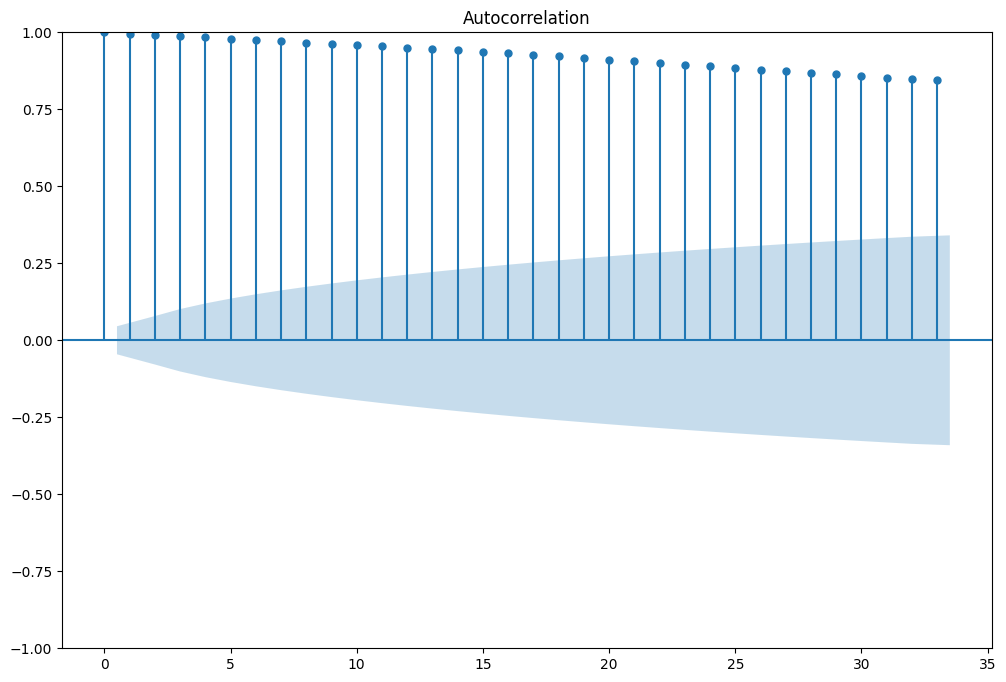

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(df_2['items'])

## Setting a new dataset with one row from the testing dataset
We visualize the data of one row in the M4 dataset and put that rows into its own dataset, which will now be used for the testing dataset.


In [6]:
df_3 = df_test.loc[2574].to_frame() # This is a dataframe housing the row that I chose.
df_3 = df_3.dropna()
df_3 = pd.DataFrame(df_3) # Just confirming that we made a new dataframe
df_3["index"] = df_3.index # There are the indexes corresponding to each element
items = df_3.iloc[:, 0]
df_3 = df_3.assign(items=items)
df_3 = df_3.drop("V1")
df_3['index'] = df_3['index'].str.replace('V', '') # Removing V from each index so that indecies are numbers
j = 1854
for i in range(len(df_3['index'])): # This makes the indecies of the testing dataset to be after the training set's indecies.
  df_3['index'][i] = j
  j = j + 1

Text(0, 0.5, 'Value')

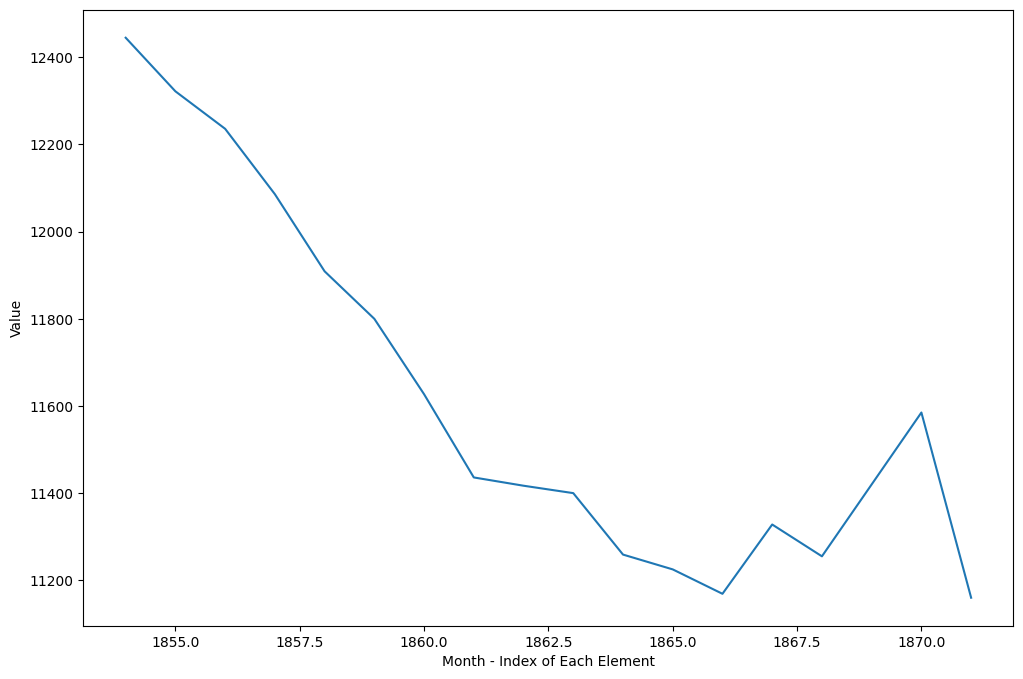

In [7]:
# This is for the testing dataset
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='index', y='items', data=df_3) # Revised based on how I formatted the dataset.
plt.xlabel('Month - Index of Each Element')
plt.ylabel('Value')

In [8]:
# This is the dataset that combines both of the other datasets for testing and training.

df_4 = df_2.append(df_3, ignore_index=True)

In [9]:
'''
# Setting up the combined figure for the zoomed out results
fig, axs = plt.subplots(3, 1, figsize=(8, 18))
'''

'\n# Setting up the combined figure for the zoomed out results\nfig, axs = plt.subplots(3, 1, figsize=(8, 18))\n'

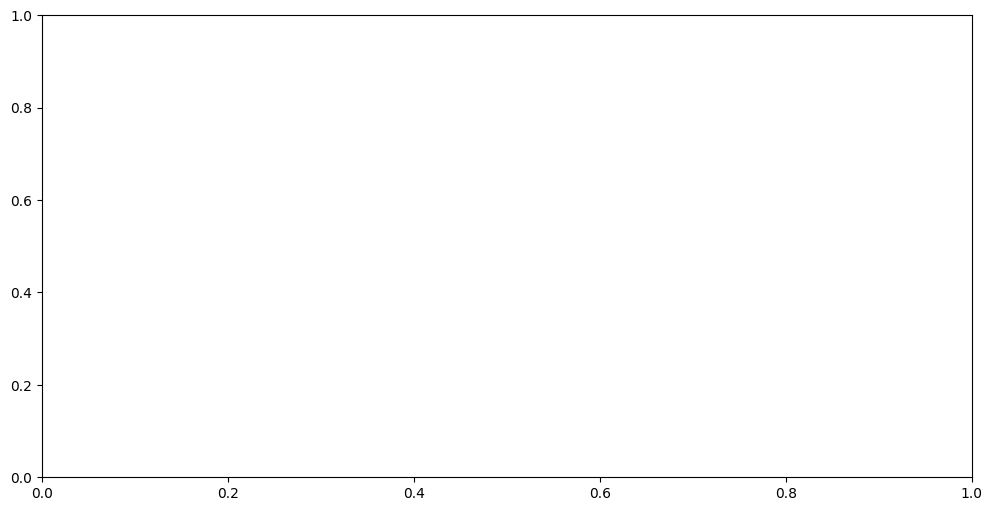

In [10]:

# Setting up the combined figure for the zoomed-in visuals.
fig, axs = plt.subplots(figsize=(12, 6))


## **Data Testing - Basic**
We prepare the training set and test set data and work with using basic GPs. The data needs to be converted to tensors to work, so some precision of the data is lost. The data is converted to int32 tensors.

In [11]:
# Normalizing df_2 and df_3

# Assigning x_train, y_train, x_test, and y_test
x_train = df_2["index"] # Months
x_train = torch.from_numpy(x_train.values.astype(np.float32))

y_train = df_2["items"] # Values
y_train = torch.from_numpy(y_train.values.astype(np.float32))

x_test = df_3["index"] # Months
x_test = torch.from_numpy(x_test.values.astype(np.float32))

y_test = df_3["items"] # Values
y_test = torch.from_numpy(y_test.values.astype(np.float32))

# Normalize x_train and x_test
x_mean = x_train.mean()
x_std = x_train.std()
x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

# Normalize y_train and y_test
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std


In [12]:
# Using the tutorial code for the simplified testing and training with the dataset.
# Will need to change the GPModel being used as needed.

# Fit the right side of the data at the change in the training graph. See sharp turn.
class GPModel(gp.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood): # Need to add ,device for this line if needed
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel() * gp.kernels.PeriodicKernel() + gp.kernels.RQKernel()) # Most effective of the combinations I tried, but by the 100th test, the negative LL is still 3023.869.
        # self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel() * gp.kernels.PeriodicKernel() + gp.kernels.LinearKernel() * gp.kernels.PeriodicKernel()) - This gives low initial losses, but they increase once we go past the 50th round.
        # self.covar_module.initialize_from_data(x_train.type(torch.float32), y_train.type(torch.float32)) # Only for the SpectralMixture Kernel
        # self.device = device
  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gp.distributions.MultivariateNormal(mean_x, covar_x)

'''
  def train(self, device="cpu"):
    super().train()

    # Check if GPU is available
    if torch.cuda.is_available():
        if device == "cuda":
            self.device = torch.device("cuda")
            print("Using GPU")
        else:
            self.device = torch.device("cpu")
            print("Using CPU")

    self.to(self.device)
'''



likelihood = gp.likelihoods.GaussianLikelihood()
# model = GPModel(x_train, y_train, likelihood, "cuda")
model = GPModel(x_train, y_train, likelihood)

In [13]:
import os
smoke_test = ("CI" in os.environ)
training_iter = 10 # else __ of training iterations
# 10000 iterations so as not to waste usage time on the GCP notebook.
# 1000 would be the most ideal, but even 500 would work to get similar results.

# Need to discuss how to set-up GPU utilization for faster training times, if needed.
'''
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU")
else:
  device = torch.device("cpu")
  print("Using CPU")
'''
# Finding the optimal parameters for the model
# model.train(device="cuda")
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Change the learning rate as needed. Lower should be better.

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

def training():
    for i in range(training_iter):
      optimizer.zero_grad()
      output = model(x_train)
      loss = -mll(output, y_train)
      loss.backward()
      print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
      optimizer.step()
        
%time training()

Iter 1/10 - Loss: 0.792
Iter 2/10 - Loss: 0.758
Iter 3/10 - Loss: 0.723
Iter 4/10 - Loss: 0.685
Iter 5/10 - Loss: 0.649
Iter 6/10 - Loss: 0.611
Iter 7/10 - Loss: 0.576
Iter 8/10 - Loss: 0.535
Iter 9/10 - Loss: 0.495
Iter 10/10 - Loss: 0.456
CPU times: user 5.67 s, sys: 24.4 ms, total: 5.7 s
Wall time: 2.97 s


/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


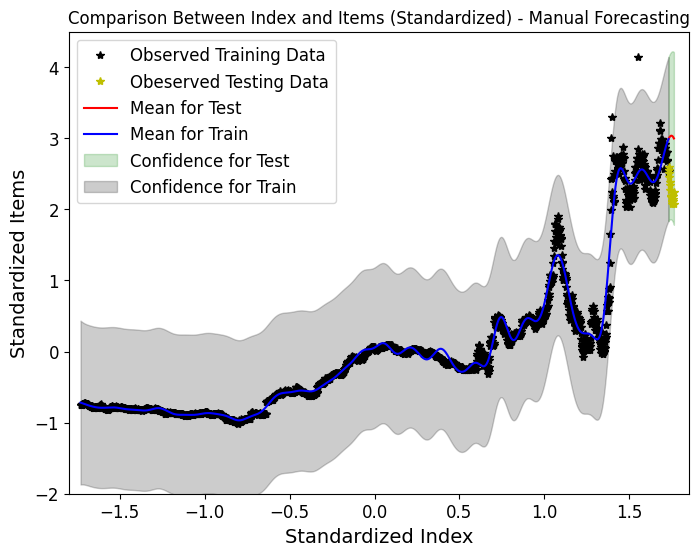

In [14]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

# Check to see if the model fits by changing the test and training sizes. Start with 100% train to see if there the gap is still present.
model.eval()
likelihood.eval()
# Concatenate x_train and x_test together. 
with torch.no_grad(), gp.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(x_train))
    pred_test = likelihood(model(x_test))

    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([x_train, x_test], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gp.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(x_train)]  # Variances for training data
    test_var = pred_all.variance[len(x_train):]   # Variances for test data


    # Initializing the plot
    fig1, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    ax.plot(x_test.numpy(), y_test.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(x_test.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(x_train.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')

    
    ax.set_ylim([-2, 4.5])
    ax.set_xlim([-1.8, 1.85])
    
    #ax.set_ylim([1.35, 3.6])
    #ax.set_xlim([1.65, 1.77])
    
    
    # Adding a title to the graph
    ax.set_title('Comparison Between Index and Items (Standardized) - Manual Forecasting')

    # Adding labels for the x and y axes
    ax.set_xlabel('Standardized Index', fontsize=14)
    ax.set_ylabel('Standardized Items', fontsize = 14)
    ax.tick_params(axis='both', labelsize=12)

    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'], fontsize = 12)
    plt.show()



In [15]:
'''
# Subplot 1 (zoomed out)
axs[0].plot(x_train.numpy(), y_train.numpy(), 'k*')
axs[0].plot(x_test.numpy(), y_test.numpy(), 'y*')
axs[0].plot(x_test.numpy(), pred_test.mean.numpy(), 'r')
axs[0].plot(x_train.numpy(), pred_train.mean.numpy(), 'b')
lower, upper = pred_train.confidence_region()
lower_2, upper_2 = pred_test.confidence_region()
axs[0].fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')
axs[0].fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')
axs[0].set_ylim([-2, 4.5])
axs[0].set_xlim([-1.8, 1.85])
axs[0].set_xlabel('Standardized Index', fontsize=14)
axs[0].set_ylabel('Standardized Items', fontsize = 14)
axs[0].set_title('Comparison Between Index and Items (Standardized) - Manual Forecasting')
'''

"\n# Subplot 1 (zoomed out)\naxs[0].plot(x_train.numpy(), y_train.numpy(), 'k*')\naxs[0].plot(x_test.numpy(), y_test.numpy(), 'y*')\naxs[0].plot(x_test.numpy(), pred_test.mean.numpy(), 'r')\naxs[0].plot(x_train.numpy(), pred_train.mean.numpy(), 'b')\nlower, upper = pred_train.confidence_region()\nlower_2, upper_2 = pred_test.confidence_region()\naxs[0].fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')\naxs[0].fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')\naxs[0].set_ylim([-2, 4.5])\naxs[0].set_xlim([-1.8, 1.85])\naxs[0].set_xlabel('Standardized Index', fontsize=14)\naxs[0].set_ylabel('Standardized Items', fontsize = 14)\naxs[0].set_title('Comparison Between Index and Items (Standardized) - Manual Forecasting')\n"

In [16]:

# Subplot 1: Manual Forecasting (zoomed in)
lower_1, upper_1 = pred_train.confidence_region()
lower_2, upper_2 = pred_test.confidence_region()

axs.plot(x_train.numpy(), y_train.numpy(), 'k*')
axs.plot(x_test.numpy(), y_test.numpy(), 'y*')

#x_combined = torch.cat([x_test, x_train], dim=0)
#mean_combined = torch.cat([pred_test.mean, pred_train.mean], dim=0)
#axs.plot(x_combined.numpy(), mean_combined.numpy(), 'c')

axs.plot(x_test.numpy(), pred_test.mean.numpy(), 'c')
axs.plot(x_train.numpy(), pred_train.mean.numpy(), 'c')
axs.fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='magenta')
axs.fill_between(x_train.numpy(), lower_1.numpy(), upper_1.numpy(), alpha=0.2, color='black')


# Evaluation for Basic Testing
We measure mean absolute error (MAE), continuous-ranked probability score (CRPS), and log-likelihood (LL) using normalized values on both of the training set and the test set.

In [17]:
!pip install git+https://github.com/jpchen/autoforecasting.git
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

  Cloning https://github.com/jpchen/autoforecasting.git to /tmp/pip-req-build-a1w2eey5
  Running command git clone --filter=blob:none --quiet https://github.com/jpchen/autoforecasting.git /tmp/pip-req-build-a1w2eey5
  Resolved https://github.com/jpchen/autoforecasting.git to commit f07246ce45673579f364939f6d1469c33b202a6b
  Preparing metadata (setup.py) ... done
  Created wheel for timeseries: filename=timeseries-0.0.0-py3-none-any.whl size=42057 sha256=20ba3925c66dacded313dbcd07ba0b4713ebbd89adb390a4c4d3b0e61c55a1b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-kv36qbbp/wheels/6b/16/5a/3645e1c96e982a34fcd4a5ff36ce5e504cdcf7f8e4cf8e97fa
Successfully built timeseries


Here we compute MAE for both training data and test data.

In [18]:
from sts.metrics import MAE
MAE_train = MAE(y_train, pred_train.mean).item()
MAE_test = MAE(y_test, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.074
Mean absolute error for test set is: 0.757


Here we compute CRPS for both training data and test data.

In [19]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
pred_train, pred_test = pred_train.mean.numpy(), pred_test.mean.numpy() # To work for the crps test.
crps_train = crps_gaussian(y_train, pred_train, train_var.sqrt())
crps_test = crps_gaussian(y_test, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 03:21:14--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.704’

metrics.py.704      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 03:21:14 (46.5 MB/s) - ‘metrics.py.704’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.144
Continuous ranked probability score for test set is: 0.489


Here we compute log-likelihood for both training data and test data.



In [20]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

Log-likelihood for training set is: -0.347
Log-likelihood for test set is: -0.392


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [21]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

,MAE,CPRS,LL
0,0.073831,0.143723,-0.347020
1,0.756806,0.488716,-0.391694



The provided table displays the metric values, with the first line representing the training set and the second line representing the test set. It's worth noting that lower values are preferable for MAE and CRPS, while higher values are desired for LL.

Upon closer examination, we have observed that the training set exhibits higher accuracy compared to the test set. To address this issue and enhance overall performance, we propose implementing a solution that involves assigning priors to the hyperparameters. Additionally, we will leverage hierarchical priors to capitalize on the joint information present in the univariate time series data.

By incorporating these priors into our model, we aim to optimize its performance and reduce the disparity between the accuracy of the training and test sets. This approach will allow us to better capture the underlying patterns and relationships within the data, ultimately improving the model's predictive capabilities.

## **Data Testing - Autoforecasting**
We prepare the training set and test set data and work with using non-standard GPs.
Before that, we need to bring in some classes and modify them to work with my changes.

In [22]:
# Setting up versions of x_train, y_train, etc. to work with the ExactGPAdditiveModel
from sts.data import df_to_tensor
df_4 = df_4.drop(columns=[2574])
df_4_float = df_4.astype('float32') # All issues with data fixed here, but the categories are still present (not a tensor).
df_4 = df_to_tensor(df_4_float, normalize_cols=True) # Now a tensor

In [23]:
from sts.data import DataTensor
# For training data
x_train = df_4[:1853, ['index']]
y_train = df_4[:1853, ['items']]

x_test = df_4[1853:, ['index']]
y_test = df_4[1853:, ['items']]

In [24]:
!pip install git+https://github.com/jpchen/autoforecasting.git

  Cloning https://github.com/jpchen/autoforecasting.git to /tmp/pip-req-build-dip58fc5
  Running command git clone --filter=blob:none --quiet https://github.com/jpchen/autoforecasting.git /tmp/pip-req-build-dip58fc5
  Resolved https://github.com/jpchen/autoforecasting.git to commit f07246ce45673579f364939f6d1469c33b202a6b
  Preparing metadata (setup.py) ... done


In [25]:
x_train.tensor = x_train.tensor.squeeze(-1)
y_train.tensor = y_train.tensor.squeeze(-1)
x_test.tensor = x_test.tensor.squeeze(-1)
y_test.tensor = y_test.tensor.squeeze(-1)

In [26]:
from sts.gp.model import ExactGPAdditiveModel 
from gpytorch.kernels import LinearKernel, RBFKernel

likelihood = gp.likelihoods.GaussianLikelihood()
# Turn off the standardizing column parameter.

model = ExactGPAdditiveModel(x_train, y_train, likelihood) # This model requires two DataTensors, unlike the other model. 
model.cov.add_trend(
    time_axis="index", kernel_cls=LinearKernel, name="LinearTrend"
)
model.cov.add_trend(
    time_axis="index",
    kernel_cls=RBFKernel,
    lengthscale=100,
    fix_lengthscale=True,
    name="RBFTrend",
)
model.cov.add_spectral_mixture(
    time_axis="index",
    num_mixtures=2,
    train_x=x_train,
    train_y=y_train,
    name="SM1",
)
model.cov.add_spectral_mixture(
    time_axis="index",
    num_mixtures=2,
    train_x=x_train,
    train_y=y_train,
    name="SM2",
) 

# Create a second RBF kernel for this one and experiment with their number as needed. Do it for this one. 


# Training loop
We train our model with our training set, and show the training time below.

In [27]:
# Fix the time issue, which is because NormalizeCols is off.

learning_rate = 0.01
num_epochs = 10 # Adjust as needed. Keep it lower until finalized.
# 1000 is a reasonable amount, as this model is quite slow at training.

trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

def train():
    for epoch in range(num_epochs):
        loss = trainer(x_train, y_train)
        print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

%time train()


epoch 1/10, loss 0.8874387741088867
epoch 2/10, loss 0.8854599595069885
epoch 3/10, loss 0.8735994696617126
epoch 4/10, loss 0.8725548982620239
epoch 5/10, loss 0.8736602663993835
epoch 6/10, loss 0.8582268357276917
epoch 7/10, loss 0.8576266169548035
epoch 8/10, loss 0.8564214706420898
epoch 9/10, loss 0.849138081073761
epoch 10/10, loss 0.8422964811325073
CPU times: user 12.3 s, sys: 249 ms, total: 12.5 s
Wall time: 6.36 s


# Predictions
We use our model to forecast the test set.



/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


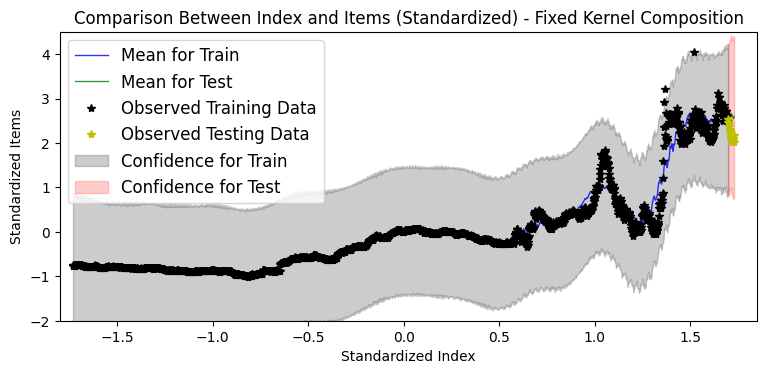

In [28]:
# Calculate GP predictions and statistics
train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))

# Create a figure and axis for the plot
fig2, ax = plt.subplots(1, 1, figsize=(9, 3.75))

# Plot the training and test mean values
ax.plot(x_train.tensor, train_mean, alpha=0.8, color='blue', linewidth=1) 
ax.plot(x_test.tensor, test_mean, alpha=0.8, color='green', linewidth=1)

#df_4_float['index'][1853:]
# Plot the actual data points
# ax.plot(x_train.tensor, y_train.tensor, 'o', markersize=1, color='black', label='actual')
ax.plot(x_train.tensor, y_train.tensor, 'k*')
ax.plot(x_test.tensor, y_test.tensor, 'y*')

# Fill the area between confidence intervals
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([x_train, x_test])
ax.fill_between(x_train, train_ci[0], train_ci[1], alpha=0.2, color='black')
ax.fill_between(x_test, test_ci[0], test_ci[1], alpha=0.2, color='red')

# Add labels, title, and legend
ax.set_xlabel('Standardized Index')
ax.set_ylabel('Standardized Items')
ax.set_title('Comparison Between Index and Items (Standardized) - Fixed Kernel Composition')
ax.legend(['Mean for Train', 'Mean for Test', 'Observed Training Data', 'Observed Testing Data', 'Confidence for Train', 'Confidence for Test'], fontsize = 12)


#ax.set_ylim([2, 3.2])
#ax.set_xlim([1.65, 1.73])

ax.set_ylim([-2, 4.5])
ax.set_xlim([-1.8, 1.85])

# Show the plot
plt.show()


The training set has tight credible intervals, while that of the test set is wider. This makes sense since the credible interval gets larger if we extrapolate from the data. But still, we would like to see better performance in the forecasting part.


In [29]:
'''
# Subplot 2 (zoomed out)
axs[1].plot(x_train.tensor, train_mean, alpha=0.8, color='blue', linewidth=1) 
axs[1].plot(x_test.tensor, test_mean, alpha=0.8, color='red', linewidth=1)
axs[1].plot(x_train.tensor, y_train.tensor, 'k*')
axs[1].plot(x_test.tensor, y_test.tensor, 'y*')
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([x_train, x_test])
axs[1].fill_between(x_train, train_ci[0], train_ci[1], alpha=0.2, color='black')
axs[1].fill_between(x_test, test_ci[0], test_ci[1], alpha=0.2, color='green')
axs[1].set_ylim([-2, 4.5])
axs[1].set_xlim([-1.8, 1.85])
axs[1].set_xlabel('Standardized Index', fontsize=14)
axs[1].set_ylabel('Standardized Items', fontsize = 14)
axs[1].set_title('Comparison Between Index and Items (Standardized) - Fixed Kernel Composition')
'''

"\n# Subplot 2 (zoomed out)\naxs[1].plot(x_train.tensor, train_mean, alpha=0.8, color='blue', linewidth=1) \naxs[1].plot(x_test.tensor, test_mean, alpha=0.8, color='red', linewidth=1)\naxs[1].plot(x_train.tensor, y_train.tensor, 'k*')\naxs[1].plot(x_test.tensor, y_test.tensor, 'y*')\nci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])\nx = torch.cat([x_train, x_test])\naxs[1].fill_between(x_train, train_ci[0], train_ci[1], alpha=0.2, color='black')\naxs[1].fill_between(x_test, test_ci[0], test_ci[1], alpha=0.2, color='green')\naxs[1].set_ylim([-2, 4.5])\naxs[1].set_xlim([-1.8, 1.85])\naxs[1].set_xlabel('Standardized Index', fontsize=14)\naxs[1].set_ylabel('Standardized Items', fontsize = 14)\naxs[1].set_title('Comparison Between Index and Items (Standardized) - Fixed Kernel Composition')\n"

In [30]:

# Subplot 2: Fixed Kernel Composition (zoomed in)
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])

#x_combined = torch.cat([x_test.tensor, x_train.tensor], dim=0)
#mean_combined = torch.cat([test_mean, train_mean], dim=0)
#axs.plot(x_combined.numpy(), mean_combined.numpy(), 'magenta', alpha=0.8, linewidth=1)

axs.plot(x_train.tensor, train_mean, alpha=0.8, color='magenta', linewidth=1) 
axs.plot(x_test.tensor, test_mean, alpha=0.8, color='magenta', linewidth=1)

#axs.plot(x_train.tensor, y_train.tensor, 'k*')
#axs.plot(x_test.tensor, y_test.tensor, 'y*')
axs.fill_between(x_train, train_ci[0], train_ci[1], alpha=0.2, color='blue')
axs.fill_between(x_test, test_ci[0], test_ci[1], alpha=0.2, color='yellow')


# Evaluation
We measure mean absolute error (MAE), continuous-ranked probability score (CRPS), and log-likelihood (LL) using normalized values on both of the training set and the test set.

In [31]:
train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))

# Needed to make sure the data works with the below test code that I had already modified to work with the manual kernel-fitting part.
x_train = x_train.tensor
y_train = y_train.tensor
x_test = x_test.tensor
y_test = y_test.tensor
pred_train = train_mean
pred_test = test_mean

Here we compute MAE for both training data and test data.

In [32]:
from sts.metrics import MAE
# train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
# test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))
# For the above two lines, the error lies in the .predict() function, which does not seem to exist anymore. 

MAE_train = MAE(y_train, pred_train).item()
MAE_test = MAE(y_test, pred_test).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.095
Mean absolute error for test set is: 0.399


Here we compute CRPS for both training data and test data.

In [33]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
crps_train = crps_gaussian(y_train, pred_train, train_var.sqrt())
crps_test = crps_gaussian(y_test, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 03:21:31--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.705’

metrics.py.705      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 03:21:31 (40.5 MB/s) - ‘metrics.py.705’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.224
Continuous ranked probability score for test set is: 0.318


Here we compute log-likelihood for both training data and test data.



In [34]:

from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')


Log-likelihood for training set is: -0.804
Log-likelihood for test set is: -0.967


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [35]:

scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure


,MAE,CPRS,LL
0,0.094629,0.224331,-0.804481
1,0.399407,0.317648,-0.966963


Above is the table showing the values of each metrics, where the first line is for the training set and the second line is for the test set. As a kind reminder, MAE and CRPS are better if they are lower, while LL is better when it's higher.


At the same time, we noticed the training set shows higher accuracy than the test set. To improve this, we will assign priors to the hyperparameters and use the hierarchical priors to gain joint information of univarite time series.

# Autoforecasting with Changepoint Detection.
We implement automated time series forecasting using advanced techniques, with a focus on changepoint detection. We explore how to identify and incorporate changepoints in time series data to improve the accuracy of our forecasts. 

In [36]:
from sts.changepoints import BinSegChangepoint
binseg = BinSegChangepoint()
changepoints = binseg.get_changepoints(x_train, y_train) #x_train and y_train should be tensors for this line.
# create kernel
from sts.gp.cov import ChangePoint
from sts.gp.cov import Trend

# Reformatting training and testing data.
train_data = df_4[:1853]
test_data = df_4[1853:]

#RBF Kernels
rbf_kernel1 = Trend(train_data, "index", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel2 = Trend(train_data, "index", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel3 = Trend(train_data, "index", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)

# Creating a list of the RBF kernels to use for the changepoint
rbf_kernels = [rbf_kernel1, rbf_kernel2, rbf_kernel3]

# ChangePoint Kernel
cp_kernel = ChangePoint(
                    train_data,
                    "index",
                    rbf_kernels,
                    changepoint_location=changepoints,
                    changepoint_steep=1.0,
                    fix_changepoint_location=True,
                    fix_changepoint_steep=True,
                    name="Changepoint - RBF",
                )

model.cov.append(cp_kernel) # Adding to your model.

In [37]:
import os
smoke_test = ("CI" in os.environ)
training_iter = 10

# Finding the optimal parameters for the model
model = GPModel(x_train, y_train, likelihood)
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Change the learning rate as needed. Lower should be better.

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

def training():
    for i in range(training_iter):
      optimizer.zero_grad()
      output = model(x_train)
      loss = -mll(output, y_train)
      loss.backward()
      print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
      optimizer.step()
        
%time training()

Iter 1/10 - Loss: 0.758
Iter 2/10 - Loss: 0.718
Iter 3/10 - Loss: 0.678
Iter 4/10 - Loss: 0.642
Iter 5/10 - Loss: 0.606
Iter 6/10 - Loss: 0.570
Iter 7/10 - Loss: 0.532
Iter 8/10 - Loss: 0.491
Iter 9/10 - Loss: 0.450
Iter 10/10 - Loss: 0.413
CPU times: user 3.93 s, sys: 90.8 ms, total: 4.02 s
Wall time: 2.01 s


/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


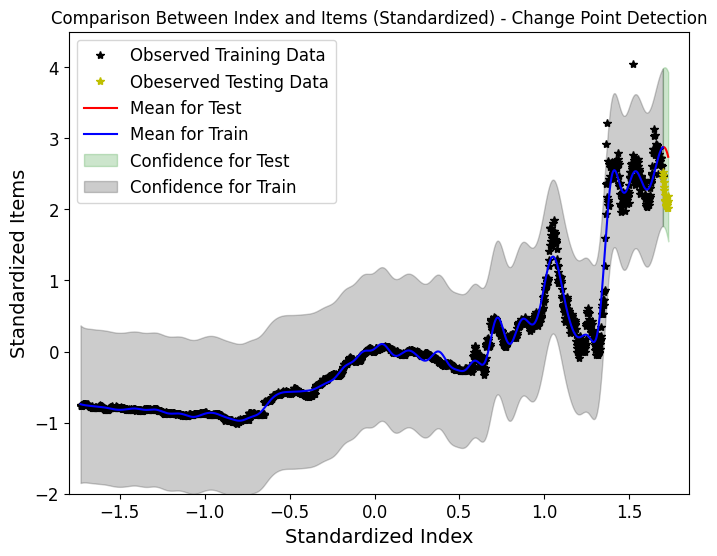

In [38]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

model.eval()
likelihood.eval()

with torch.no_grad(), gp.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(x_train))
    pred_test = likelihood(model(x_test))
    
    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([x_train, x_test], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gp.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(x_train)]  # Variances for training data
    test_var = pred_all.variance[len(x_train):]   # Variances for test data


    # Initializing the plot
    fig3, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    ax.plot(x_test.numpy(), y_test.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(x_test.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(x_train.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')

    
    #ax.set_ylim([0.75, 4.3])
    #ax.set_xlim([1.65, 1.73])
    
    ax.set_ylim([-2, 4.5])
    ax.set_xlim([-1.8, 1.85])
    
    # Adding a title to the graph
    ax.set_title('Comparison Between Index and Items (Standardized) - Change Point Detection')

    # Adding labels for the x and y axes
    ax.set_xlabel('Standardized Index', fontsize=14)
    ax.set_ylabel('Standardized Items', fontsize = 14)
    ax.tick_params(axis='both', labelsize=12)

    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'], fontsize = 12)
    plt.show()


In [39]:
'''
# Subplot 3 (zoomed out)
axs[2].plot(x_train.numpy(), y_train.numpy(), 'k*')
axs[2].plot(x_test.numpy(), y_test.numpy(), 'y*')
axs[2].plot(x_test.numpy(), pred_test.mean.numpy(), 'r')
axs[2].plot(x_train.numpy(), pred_train.mean.numpy(), 'b')
lower, upper = pred_train.confidence_region()
lower_2, upper_2 = pred_test.confidence_region()
axs[2].fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')
axs[2].fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')
axs[2].set_ylim([-2, 4.5])
axs[2].set_xlim([-1.8, 1.85])
axs[2].set_xlabel('Standardized Index', fontsize=14)
axs[2].set_ylabel('Standardized Items', fontsize = 14)
axs[2].set_title('Comparison Between Index and Items (Standardized) - Change Point Detection')
# Adjust layout to prevent clipping of titles
plt.tight_layout()
'''

"\n# Subplot 3 (zoomed out)\naxs[2].plot(x_train.numpy(), y_train.numpy(), 'k*')\naxs[2].plot(x_test.numpy(), y_test.numpy(), 'y*')\naxs[2].plot(x_test.numpy(), pred_test.mean.numpy(), 'r')\naxs[2].plot(x_train.numpy(), pred_train.mean.numpy(), 'b')\nlower, upper = pred_train.confidence_region()\nlower_2, upper_2 = pred_test.confidence_region()\naxs[2].fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')\naxs[2].fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')\naxs[2].set_ylim([-2, 4.5])\naxs[2].set_xlim([-1.8, 1.85])\naxs[2].set_xlabel('Standardized Index', fontsize=14)\naxs[2].set_ylabel('Standardized Items', fontsize = 14)\naxs[2].set_title('Comparison Between Index and Items (Standardized) - Change Point Detection')\n# Adjust layout to prevent clipping of titles\nplt.tight_layout()\n"

In [40]:

# Subplot 3: Change Point Detection (zoomed in)
lower_3, upper_3 = pred_train.confidence_region()
lower_4, upper_4 = pred_test.confidence_region()
#ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
#ax.plot(x_test.numpy(), y_test.numpy(), 'y*')

x_combined = torch.cat([x_test, x_train], dim=0)
#mean_combined = torch.cat([pred_test.mean, pred_train.mean], dim=0)
#axs.plot(x_combined.numpy(), mean_combined.numpy(), 'k')

axs.plot(x_train.numpy(), pred_train.mean.numpy(), 'g')
axs.plot(x_test.numpy(), pred_test.mean.numpy(), 'g')

axs.fill_between(x_test.numpy(), lower_4.numpy(), upper_4.numpy(), alpha=0.2, color='purple')
axs.fill_between(x_train.numpy(), lower_3.numpy(), upper_3.numpy(), alpha=0.2, color='red')


# Evaluation for ChangePoint Testing
We measure mean absolute error (MAE), continuous-ranked probability score (CRPS), and log-likelihood (LL) using normalized values on both of the training set and the test set.

In [41]:
from sts.metrics import MAE
MAE_train = MAE(y_train, pred_train.mean).item()
MAE_test = MAE(y_test, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.067
Mean absolute error for test set is: 0.637


In [42]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
pred_train, pred_test = pred_train.mean.numpy(), pred_test.mean.numpy() # To work for the crps test.
crps_train = crps_gaussian(y_train, pred_train, train_var.sqrt())
crps_test = crps_gaussian(y_test, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 03:21:36--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.706’

metrics.py.706      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 03:21:36 (35.4 MB/s) - ‘metrics.py.706’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.137
Continuous ranked probability score for test set is: 0.397


In [43]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

Log-likelihood for training set is: -0.305
Log-likelihood for test set is: -0.361


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [44]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

,MAE,CPRS,LL
0,0.067378,0.136582,-0.305284
1,0.636953,0.397414,-0.361037


In [45]:
'''
# Display the combined figure for the zoomed out figures.
fig.legend(['Observed Training Data', 'Observed Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train'], fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)
display(fig)
'''

"\n# Display the combined figure for the zoomed out figures.\nfig.legend(['Observed Training Data', 'Observed Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train'], fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)\ndisplay(fig)\n"

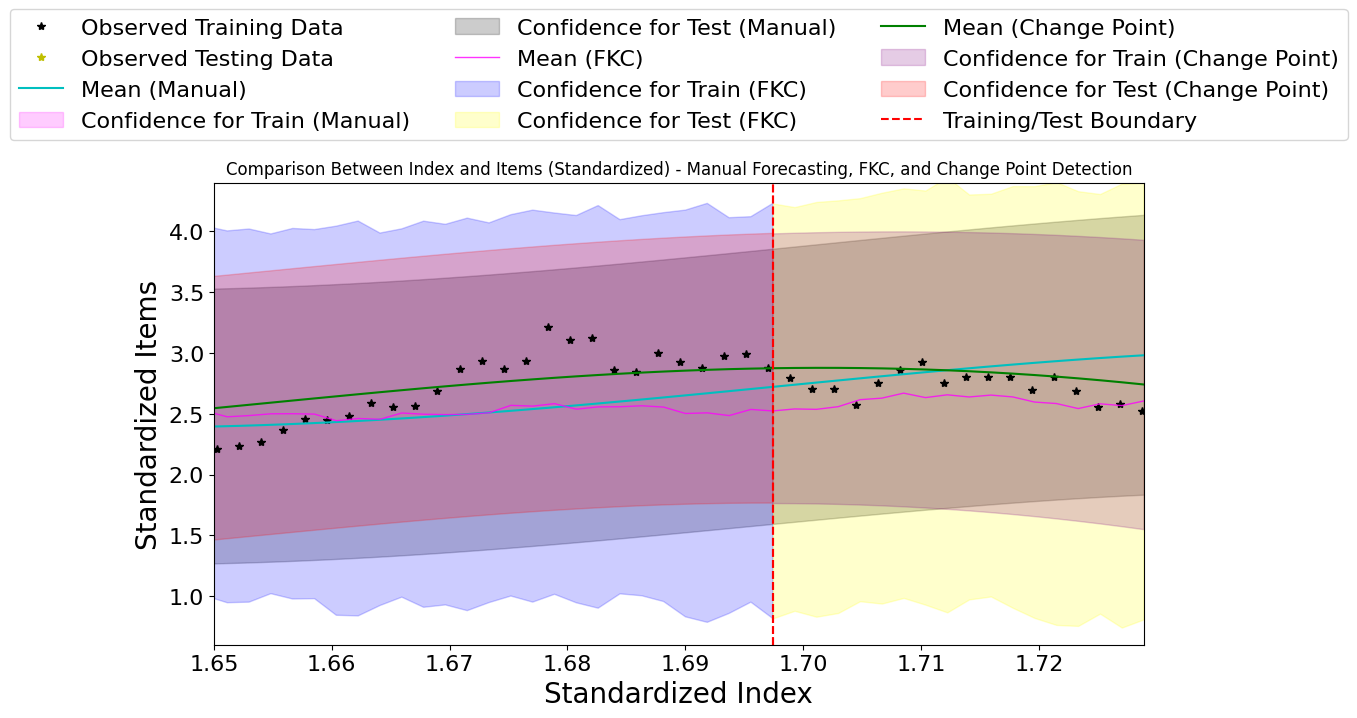

In [47]:

# Display the combined figure for the zoomed in visuals.
axs.set_ylim([0.6, 4.4])
axs.set_xlim([1.65, 1.7289])
#axs.set_ylim([-2, 4.5])
#axs.set_xlim([-1.8, 1.85])
axs.set_title('Comparison Between Index and Items (Standardized) - Manual Forecasting, FKC, and Change Point Detection')
axs.set_xlabel('Standardized Index', fontsize=20)
axs.set_ylabel('Standardized Items', fontsize=20)
axs.tick_params(axis='both', labelsize=16)
training_end_index = len(x_train)
axs.axvline(x=1.6974, color='red', linestyle='--')

legend = axs.legend(['Observed Training Data', 'Observed Testing Data', 'Mean (Manual)', 'Mean for Train (Manual)', 'Confidence for Train (Manual)', 'Confidence for Test (Manual)', 
            'Mean (FKC)', 'Mean for Test (FKC)', 'Confidence for Train (FKC)', 'Confidence for Test (FKC)',
            'Mean (Change Point)', 'Mean for Train (Change Point)', 'Confidence for Train (Change Point)', 'Confidence for Test (Change Point)', 'Training/Test Boundary'], fontsize=10)


items_to_skip = ['Mean for Train (Manual)', 'Mean for Test (FKC)', 'Mean for Train (Change Point)']
handles, labels = [], []
for handle, label in zip(legend.legendHandles, legend.get_texts()):
    if label.get_text() not in items_to_skip:
        handles.append(handle)
        labels.append(label.get_text())

# Create a new legend with updated handles and labels
axs.legend(handles, labels,fontsize=16, loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=3)

    
display(fig)


# References

[1] Corani, G., Benavoli, A., Augusto, J. and Zaffalon, M., 2020. Automatic Forecasting using Gaussian Processes. arXiv preprint arXiv:2009.08102.